Features extraction from the EEG signal in the study of ASMR

Purpose of this project is comparing StrongASMR responders with PreRelaxed state by extracting topological features from EEG signals, to see how ASMR affects on topological features. Our goal is to create persistent diagram for both cases and using Wasserstein distance understand the difference between them.  

For this project we are using datasets from the report: https://research.gold.ac.uk/id/eprint/31487/10/1-s2.0-S0010945222000119-main.pdf

Datasets can be found: https://drive.google.com/drive/folders/1Z0QYSA7o3nBicBKlLk8X4jG97UGYg_wl

In [ ]:
!pip install mne
!pip install ipywidgets
!pip install pyvistaqt
!pip install PySide6
!pip install mne[hdf5]
!pip install --index-url=https://download.qt.io/snapshots/ci/pyside/6.0.0/latest pyside6 --trusted-host download.qt.io
!pip install giotto-tda
!pip install -U mne-connectivity
!pip install latex

In [ ]:
import sys
import random
#from PySide6 import *
from mne.datasets import testing
from mne import Epochs, io, pick_types
from mne.event import define_target_events
import os
import numpy as np
import pandas
import matplotlib.pyplot as plt
import mne
from mne.datasets import somato
from mne.time_frequency import tfr_morlet
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding
from gtda.plotting import plot_point_cloud
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import scipy as sp
import statistics, math
import random as rd
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
from math import sqrt, ceil
from sklearn import metrics
from sklearn import decomposition, cluster
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import correlation
from IPython.display import display
import mne
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap, annotate_muscle_zscore, peak_finder,
                               find_eog_events, find_ecg_events, ica_find_ecg_events, find_bad_channels_maxwell)
from mne.time_frequency import (tfr_array_multitaper, psd_array_multitaper, csd_array_multitaper, csd_array_morlet)

from mne_connectivity import seed_target_indices, spectral_connectivity_epochs, spectral_connectivity_time
import plotly.graph_objects as go
from gtda.time_series import SingleTakensEmbedding, TakensEmbedding, takens_embedding_optimal_parameters
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve, Scaler, Filtering, Amplitude, PersistenceEntropy, NumberOfPoints
from gtda.plotting import plot_point_cloud
from gtda.diagrams import PairwiseDistance
from gtda.diagrams import PersistenceLandscape
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_heatmap
import matplotlib.pyplot as plt
plt.rc('figure', max_open_warning=200)
%matplotlib notebook
%matplotlib inline
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt

Reading Data

For the experiment participants supposed to watched an individualised ASMR video with 10 minutes du- ration to maximize the possibility of ASMR.
Each participant choosed ASMR video and watched it twice. First time scrambled (control), then in original form (experiment). The control version of ASMR video was created from ASMR ex- perimental video(the same one) by randomly shuffling temporal continuity every 5 s.
First, each subject had 5 min of resting-state EEG and ECG recorded with eyes closed, and then 5 min with eyes open. Then, two ASMR videos were watched meanwhile the current state was reported with a presentation(duration 2 minutes) of a fixation cross between videos. After that was presented a 2 minute fixation cross, followed by another unreported study. In the end the resting state was recorded again. The order of the ASMR videos(experimental and control) was balanced across the participant group.
As there was noticed unknown duration of ASMR decay effect the self reported states ‘Base- line’ and ‘Relaxed’ were divided by their relation in time to the ASMR states (WeakASMR and StrongASMR). When ASMR was reported (WeakASMR or StrongASMR), prefix ‘Post’ was added to subsequent states of Baseline or Relaxed(PostBaseline and PostRelaxed). Similarly, to Base- line or Relaxed states, which were reported before ASMR were added prefix ‘Pre’ (PreBaseline, PreRelaxed). These state-specific data epochs were collated if a participant left and re-entered a
16
state multiple times throughout the video.
EEG signals were recorded with 64 Ag-AgCl electrodes, which were placed in accordance to the extended 10-20 system, using the BioSemi ActiveTwo head cap and the ActiveTwo BioSemi system amplifier (BioSemi, Amsterdam, The Netherlands). The EEG signal was amplified by a BioSemi ActiveTwo amplifier and sampled at 512 Hz.
In data we have 67 channels. We will use all channels information in the scope of this work

In [ ]:
fname = "/content/P061_Run1_clean.set"
mn_fdt = "/content/P061_Run1_clean.fdt"
data = mne.read_epochs_eeglab(fname, montage_units = "m")
mapping = {"EXG3": "ecg", #EXG3 represents the difference waveform for the bipolar ECG recording.
           "EXG4": "eog", #EXG4 represents the difference waveform for the bipolar VEOG recording.
           "EXG5": "eog"} #EXG5 represents the difference waveform for the bipolar HEOG recording.
data.set_channel_types(mapping)
data.set_montage("biosemi64")

Extracting parameters from /content/P061_Run1_clean.set...
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated
Ready.


Number of events,446
Events,B1(Pre_Baseline): 23B2(Pre_Relaxed): 39B3(WeakASMR): 155B4(StrongASMR): 54B5(Post_Relaxed): 150B5(Post_Relaxed)/B5(Post_Relaxed): 2B6(Post_Baseline): 23
Time range,-1.000 – 0.998 s
Baseline,off


Channels

['Fp1', 'AF7', 'AF3', 'F1', 'F3', 'F5', 'F7', 'FT7', 'FC5', 'FC3', 'FC1', 'C1', 'C3', 'C5', 'T7', 'TP7', 'CP5', 'CP3', 'CP1', 'P1', 'P3', 'P5', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Iz', 'Oz', 'POz', 'Pz', 'CPz', 'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP8', 'CP6', 'CP4', 'CP2', 'P2', 'P4', 'P6', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'EXG3', 'EXG4', 'EXG5']


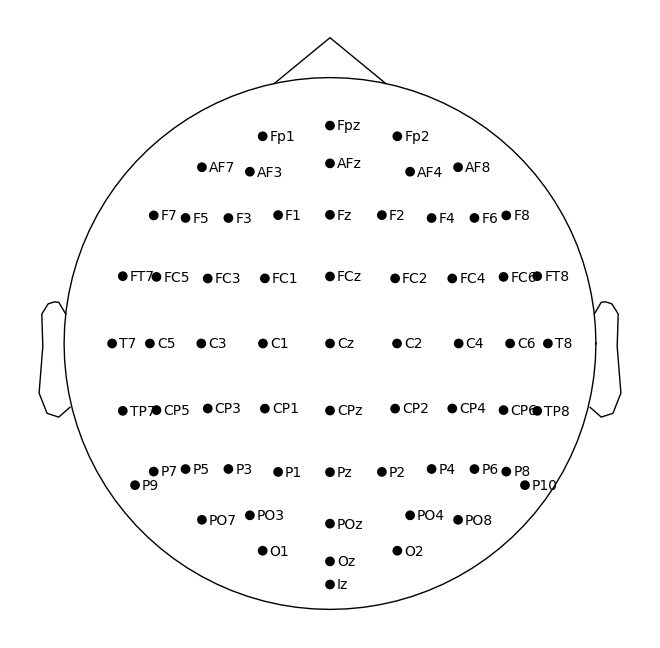

In [ ]:
print(data.ch_names)
data.plot_sensors(kind="topomap", ch_type="all", show_names = True) #to see all EEG channels
plt.plot(1)

Explanation of the plot above:

There was noticed changes in signals of EEG during ASMR, compared with relaxed and base- line states. High gamma(52-80 Hz) was decreasing in compare of Relaxed state. Alpha (8-13 Hz) was increasing and delta (1-4 Hz) was decreasing compared with Baseline state. Besides this, during ASMR power of low-middle frequency ranges (8-18 Hz) were increased and high frequency (21-80 Hz) were decreased. In the source space ASMR decay effects reduced high-beta and gamma power (21-80 Hz), also gamma (30-80 Hz). Enhaced alpha persists up to 45 minutes post self- reported ASMR. Other high frequency’s are being shifted to low frequencies(1-8 Hz). According this result, we can conclude, that ASMR is able to cause stable relaxation state, and ASMR tin- gling sensations can come from high frequencies decreasing.

In [ ]:
events= data.events
event_dict = {
    "Pre_Baseline": 1,
    "Pre_Relaxed": 2,
    "WeakASMR": 3,
    "StrongASMR": 4,
    "Post_Relaxed": 5,
    "Post_Relaxed/Post_Relaxed": 6,
    "Post_Baseline": 7,
}

At first we create a plot for events versus time(in seconds). In the scope of this project we will analyse PreRelaxed(39) and StrongASMR(54) events

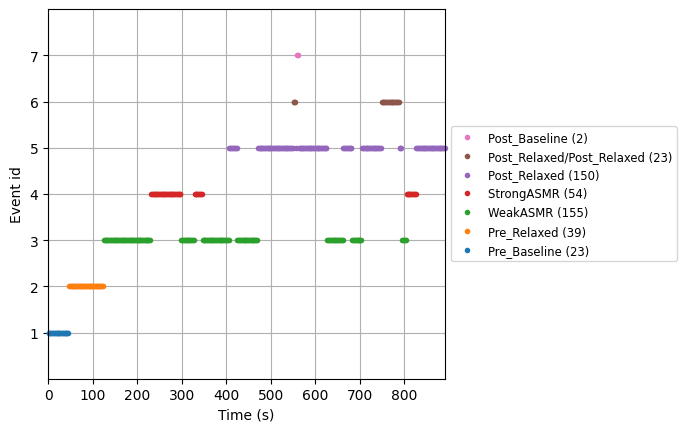

In [ ]:
fig = mne.viz.plot_events(
    events, sfreq=data.info["sfreq"],  event_id=event_dict)#events versus time(seconds)
plt.plot(1)

Separating events, creating new datas

In [ ]:
prerel = data[23:62] #Pre_Relaxed state
prerel

Number of events,39
Events,B2(Pre_Relaxed): 39
Time range,-1.000 – 0.998 s
Baseline,off


In [ ]:
int1 = data[115:149]
int2 = data[164:173]
int3 = data[402:413]
list1 = [int1,int2,int3]#115-149 34 strongASMR , 164-173 9 strongASMR, 402-413 11strongASMR
strASMR = mne.concatenate_epochs(list1)
strASMR

Not setting metadata
54 matching events found
No baseline correction applied


Number of events,54
Events,B4(StrongASMR): 54
Time range,-1.000 – 0.998 s
Baseline,off


We take two groups from events of the whole data, and, using Taken’s embedding method trans- form noisy data to point cloud. During this step we also calculating time delay and dimension to capture the approximate topological space.

For Pre_Relaxed state

In [ ]:
prel_main = prerel.get_data()
print(prel_main.shape)

(39, 67, 1024)


In [ ]:
n_samples_pr = prel_main.shape[0]
n_channels_pr = prel_main.shape[1]
n_times_pr = prel_main.shape[2]

In [ ]:
pr_rel_samp = prerel.get_data(picks=0, item=0).reshape(prerel.get_data().shape[2])
time_delayr, dimensionr = takens_embedding_optimal_parameters(pr_rel_samp,10, 10) #finding time delay and dimension
print('time_delay = ', time_delayr)
print('dimension = ', dimensionr)

time_delay =  10
dimension =  6


In [ ]:
embedding_dimensionr = dimensionr
embedding_time_delayr = time_delayr
strider = 3

attractor = TakensEmbedding( # Using Taken's embedding method
    time_delay=embedding_time_delayr,
    dimension=embedding_dimensionr,
    stride=strider,
)

In [ ]:
pr_all_cl = []

for i in range(n_samples_pr):
    pr_all_cl.append(attractor.fit_transform(prel_main[i]))
pr_all_cl = np.array(pr_all_cl)

print(pr_all_cl.shape)

attractor.fit_transform_plot(prel_main[38]) #point cloud

(39, 67, 325, 6)


array([[[-5.01811552e-06, -4.73341608e-06,  1.27925425e-05,
          8.39081860e-06,  1.84899616e-05,  4.22261667e-06],
        [-4.55767632e-06,  5.01523018e-06,  1.01671724e-05,
          1.41568508e-05,  1.47778721e-05,  1.05484428e-05],
        [-5.04678583e-06, -6.18394279e-06,  1.30946360e-05,
          2.00809822e-05,  4.73417711e-06,  1.68676639e-06],
        ...,
        [-8.20486832e-06, -1.16389141e-05, -1.90188198e-05,
         -1.56674032e-05, -1.42517796e-05, -5.51316214e-06],
        [-6.99719763e-06, -5.24650383e-06, -1.52459745e-05,
         -2.16297035e-05, -1.36884594e-05,  1.84354579e-06],
        [-1.63878441e-05, -8.01618576e-06, -1.50906754e-05,
         -1.37013550e-05, -9.64647293e-06, -3.97858739e-06]]])

In [ ]:
homology_dimensions = [0, 1, 2]

persistencep = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions,
    n_jobs=-1,
)

pr_all_di = []

for i in range(n_samples_pr):
    pr_all_di.append(persistencep.fit_transform(pr_all_cl[i]))

In [ ]:
print(pr_all_di[0].shape)
print(pr_all_di[1].shape)
print(pr_all_di[2].shape)

(67, 735, 3)
(67, 757, 3)
(67, 759, 3)


Using derived point cloud and Vietoris-Rips complex we obtain the persistence diagram for both cases. We are working in homology dimensions [0, 1, 2] and its corresponding persistence dia- grams.

In [ ]:
print("Persistence diagram for preRelaxed state")
perspr = persistencep.fit_transform_plot(pr_all_cl[38])

Persistence diagram for preRelaxed state


In [ ]:
landscape = PersistenceLandscape()

landscape.fit_transform_plot(perspr)

array([[[0.00000000e+00, 1.70744254e-07, 3.41488509e-07, 5.12232763e-07,
         6.82977017e-07, 8.53721271e-07, 1.02446553e-06, 1.19520978e-06,
         1.36595403e-06, 1.53669829e-06, 1.70744254e-06, 1.87818680e-06,
         2.04893105e-06, 2.21967531e-06, 2.39041956e-06, 2.56116381e-06,
         2.73190807e-06, 2.90265232e-06, 3.07339658e-06, 3.24414083e-06,
         3.41488509e-06, 3.58562934e-06, 3.75637359e-06, 3.92711785e-06,
         4.09786210e-06, 4.26860636e-06, 4.43935061e-06, 4.61009486e-06,
         4.78083912e-06, 4.95158337e-06, 5.12232763e-06, 5.29307188e-06,
         5.46381614e-06, 5.63456039e-06, 5.80530464e-06, 5.97604890e-06,
         6.14679315e-06, 6.31753741e-06, 6.48828166e-06, 6.65902592e-06,
         6.82977017e-06, 7.00051442e-06, 7.17125868e-06, 7.34200293e-06,
         7.51274719e-06, 7.68349144e-06, 7.85423570e-06, 8.02497995e-06,
         8.19572420e-06, 8.36646846e-06, 8.36646846e-06, 8.19572420e-06,
         8.02497995e-06, 7.85423570e-06, 7.68349144

In [ ]:
PE = PersistenceEntropy(normalize=True) #driving normalized persistent entropy

pr_all_PE_norm = []

for i in range(n_samples_pr):
    pr_all_PE_norm.append(PE.fit_transform(pr_all_di[i]))

pr_all_PE_norm = np.array(pr_all_PE_norm)

print(pr_all_PE_norm.shape)

(39, 67, 3)


For StrongASMR state

In [ ]:
sta_main = strASMR.get_data()
print(sta_main.shape)

(54, 67, 1024)


In [ ]:
n_samples_sta = sta_main.shape[0]
n_channels_sta = sta_main.shape[1]
n_times_sta = sta_main.shape[2]

In [ ]:
sta_rel_samp = strASMR.get_data(picks=0, item=0).reshape(strASMR.get_data().shape[2])
time_delays, dimensions = takens_embedding_optimal_parameters(sta_rel_samp,10, 10)
print('time_delay = ', time_delays)
print('dimension = ', dimensions)

time_delay =  10
dimension =  7


In [ ]:
embedding_dimensions = dimensions
embedding_time_delays = time_delays
strider = 3 # downsampling

attractor = TakensEmbedding(
    time_delay=embedding_time_delays,
    dimension=embedding_dimensions,
    stride=strider,
)

In [ ]:
sta_all_cl = []

for i in range(n_samples_sta):
    sta_all_cl.append(attractor.fit_transform(sta_main[i]))
sta_all_cl = np.array(sta_all_cl)

print(sta_all_cl.shape)

attractor.fit_transform_plot(sta_main[53])

(54, 67, 322, 7)


array([[[-2.48891296e-05, -1.94682274e-05, -1.72976665e-05, ...,
          1.23682237e-06, -9.45918083e-06, -1.10652380e-05],
        [-1.75531921e-05, -2.05108109e-05, -1.60249100e-05, ...,
          2.10749960e-06, -1.66926384e-05, -1.74846020e-05],
        [-2.98325882e-05, -9.81955814e-06, -1.17402496e-05, ...,
         -3.75589132e-06, -1.33858910e-05, -2.09281349e-05],
        ...,
        [-3.80489922e-06,  1.25636196e-06,  1.55818033e-06, ...,
         -2.30960503e-07, -1.30913792e-05, -7.89971256e-06],
        [ 1.62331605e-06,  1.08601165e-06,  1.56919203e-05, ...,
          1.32184947e-06, -6.16999483e-06, -5.37991858e-06],
        [-1.61285079e-06,  8.99626064e-06,  6.24021482e-06, ...,
         -3.78133154e-06, -5.58400917e-06, -7.28140068e-06]]])

In [ ]:
homology_dimensions = [0, 1, 2]

persistences = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions,
    n_jobs=-1,
)

sta_all_di = []

for i in range(n_samples_sta):
    sta_all_di.append(persistences.fit_transform(sta_all_cl[i]))

In [ ]:
print(sta_all_di[0].shape)
print(sta_all_di[1].shape)
print(sta_all_di[2].shape)

(67, 786, 3)
(67, 809, 3)
(67, 824, 3)


In [ ]:
print("Persistence diagram for strong ASMR")
perssta = persistences.fit_transform_plot(sta_all_cl[53])

Persistence diagram for strong ASMR


From persistence diagrams we notice that the birth - death points for homological dimension 1 and 2 are close to the diagonal. In StrongASMR’s persistence diagram points are more collected in front of diagonal, but there is one point, which is far away from all. To understand where and why this is coming like this, we need to do additional steps and cross checks. For the relaxed group birth-death points are more disperse in front of the diagonal in comparison with the first case.

In [ ]:
landscape = PersistenceLandscape()

landscape.fit_transform_plot(perssta)

array([[[0.00000000e+00, 2.52208228e-07, 5.04416455e-07, 7.56624683e-07,
         1.00883291e-06, 1.26104114e-06, 1.51324937e-06, 1.76545759e-06,
         2.01766582e-06, 2.26987405e-06, 2.52208228e-06, 2.77429050e-06,
         3.02649873e-06, 3.27870696e-06, 3.53091519e-06, 3.78312341e-06,
         4.03533164e-06, 4.28753987e-06, 4.53974810e-06, 4.79195632e-06,
         5.04416455e-06, 5.29637278e-06, 5.54858101e-06, 5.80078923e-06,
         6.05299746e-06, 6.30520569e-06, 6.55741392e-06, 6.80962214e-06,
         7.06183037e-06, 7.31403860e-06, 7.56624683e-06, 7.81845505e-06,
         8.07066328e-06, 8.32287151e-06, 8.57507974e-06, 8.82728796e-06,
         9.07949619e-06, 9.33170442e-06, 9.58391265e-06, 9.83612087e-06,
         1.00883291e-05, 1.03405373e-05, 1.05927456e-05, 1.08449538e-05,
         1.10971620e-05, 1.13493702e-05, 1.16015785e-05, 1.18537867e-05,
         1.21059949e-05, 1.23582031e-05, 1.23582031e-05, 1.21059949e-05,
         1.18537867e-05, 1.16015785e-05, 1.13493702

For homology dimension 0 there is no pattern difference, only values are different, but still these landscapes help us to differentiate two states, as for homology dimension 1 there is clear pattern difference. For homology dimension 2 we can also detect big difference between two groups. In landscape of strongASMR values for H1 are more right oriented, H2 also a bit right oriented.

In [ ]:
PE = PersistenceEntropy(normalize=True)

sta_all_PE_norm = []

for i in range(n_samples_sta):#n_samples_sta
    sta_all_PE_norm.append(PE.fit_transform(sta_all_di[i]))

sta_all_PE_norm = np.array(sta_all_PE_norm)

print(sta_all_PE_norm.shape)

(54, 67, 3)


PCA classification

In [ ]:
dt_2d_sta = np.array([sta_all_PE_norm.flatten() for sta_all_PE_norm in sta_all_cl]) #Flattening data for PCA
dt_2d_pr = np.array([pr_all_PE_norm.flatten() for pr_all_PE_norm in pr_all_cl])

In [ ]:
dt_2d_sta

In [ ]:
dt_2d_pr

In [ ]:
pca_sta = PCA(n_components=2)

# Compute PCA
pca_sta.fit_transform(dt_2d_sta)

# Define components
comp_sta = pca_sta.components_

# Instantiate PCA solver
pca_pr = PCA(n_components=2)

# Compute PCA
pca_pr.fit_transform(dt_2d_pr)

# Define components
comp_pr = pca_pr.components_

In [ ]:
print('Singular values for sta dataset:', pca_sta.singular_values_)
print('Singular values for pr dataset:', pca_pr.singular_values_)

Singular values for sta dataset: [0.01429161 0.01238431]
Singular values for pr dataset: [0.00611556 0.00597112]


In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

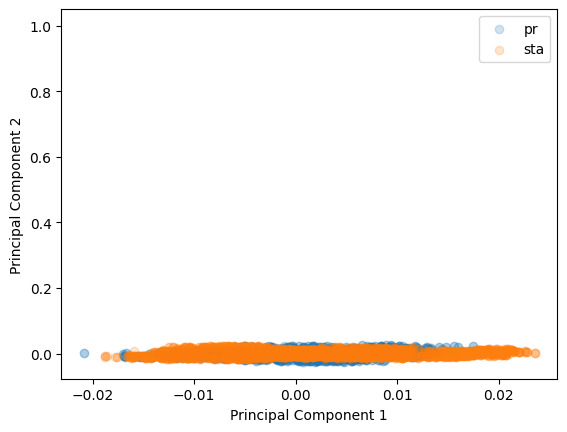

In [ ]:
plt.figure()
plt.scatter(comp_pr[0], comp_pr[1], label='pr', alpha=0.2)
plt.scatter(comp_sta[0], comp_sta[1], label='sta', alpha=0.2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.plot(1)


From PCA plot the difference between states is very little, but singular values of states differs approximately 2 times(strongASMR’s is bigger). For both state is common, that first component value is bigger than second one.